<a href="https://colab.research.google.com/github/elangbijak4/Security_Research/blob/main/Tool19_Almudaya_Evolution_Algorithm_For_Algorithm_Discovery_on_Cyber_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.9 MB/s eta 0:00:00


In [2]:
import operator
import random
import numpy as np
import pandas as pd
from deap import algorithms, base, creator, gp, tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

In [3]:
# Load dataset (NSL-KDD)
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
column_names = [  # Sesuaikan dengan nama kolom dataset NSL-KDD
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
    'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]
data = pd.read_csv(url, header=None, names=column_names)

In [21]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,1,20,9,482,0,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
0,2,44,9,143,0,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
0,1,49,5,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
0,1,24,9,229,8153,0,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
0,1,24,9,196,420,0,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,49,5,0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
8,2,49,9,102,145,0,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
0,1,54,9,2072,384,0,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
0,1,30,5,0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [23]:
# Preprocessing data
# Encode categorical features
categorical_columns = ['duration','protocol_type', 'service', 'flag','dst_host_srv_rerror_rate']
le_dict = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le  # Save the label encoder for possible inverse_transform later

In [24]:
X = data.iloc[:, :-1].values  # Fitur
y = data.iloc[:, -1].values  # Label

In [25]:
X

array([[1.0e+00, 2.0e+01, 9.0e+00, ..., 5.0e-02, 0.0e+00, 1.1e+01],
       [2.0e+00, 4.4e+01, 9.0e+00, ..., 0.0e+00, 0.0e+00, 1.1e+01],
       [1.0e+00, 4.9e+01, 5.0e+00, ..., 0.0e+00, 0.0e+00, 9.0e+00],
       ...,
       [1.0e+00, 5.4e+01, 9.0e+00, ..., 1.0e-02, 0.0e+00, 1.1e+01],
       [1.0e+00, 3.0e+01, 5.0e+00, ..., 0.0e+00, 0.0e+00, 9.0e+00],
       [1.0e+00, 2.0e+01, 9.0e+00, ..., 0.0e+00, 0.0e+00, 1.1e+01]])

In [26]:
y

array([20, 15, 19, ..., 18, 20, 21])

In [27]:
# Encode label
y = np.where(y == 'normal', 0, 1)

In [28]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [29]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# Buat tipe individu dan fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [32]:
# Buat Primitive Set untuk GP
pset = gp.PrimitiveSet("MAIN", X_train.shape[1])
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))
#pset.addEphemeralConstant("rand101", functools.partial(random.randint, -1, 1))
pset.addEphemeralConstant("rand101", lambda: random.uniform(-1, 1))

In [33]:
# Buat toolbox untuk GP
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("compile", gp.compile, pset=pset)

In [34]:
# Define evaluation function
def evaluate(individual):
    func = toolbox.compile(expr=individual)
    predictions = np.array([func(*x) for x in X_train])
    predictions = np.round(predictions).astype(int)
    accuracy = accuracy_score(y_train, predictions)
    return accuracy,

toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [35]:
# Inisialisasi parameter evolusi
population = toolbox.population(n=300)
hall_of_fame = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [36]:
# Jalankan algoritma evolusi
population, log = algorithms.eaSimple(population, toolbox, 0.5, 0.2, 40, stats=stats, halloffame=hall_of_fame, verbose=True)

gen	nevals	avg     	std     	min	max
0  	300   	0.123405	0.211434	0  	1  
1  	170   	0.244397	0.26021 	0  	1  
2  	166   	0.351141	0.281394	0  	1  
3  	170   	0.412745	0.307435	0  	1  
4  	194   	0.42954 	0.327995	0  	1  
5  	176   	0.494471	0.358536	0  	1  
6  	182   	0.507645	0.380027	0  	1  
7  	195   	0.545845	0.399831	0  	1  
8  	173   	0.622324	0.408721	0  	1  
9  	188   	0.675483	0.404877	0  	1  
10 	178   	0.73723 	0.412223	0  	1  
11 	194   	0.789164	0.384054	0  	1  
12 	201   	0.789471	0.391437	0  	1  
13 	180   	0.823883	0.363312	0  	1  
14 	172   	0.828114	0.359668	0  	1  
15 	172   	0.832553	0.362607	0  	1  
16 	161   	0.816458	0.368513	0  	1  
17 	174   	0.801564	0.375873	0  	1  
18 	181   	0.829104	0.355572	0  	1  
19 	177   	0.839514	0.349611	0  	1  
20 	191   	0.790933	0.383958	0  	1  
21 	169   	0.851417	0.337588	0  	1  
22 	200   	0.79281 	0.386954	0  	1  
23 	162   	0.86431 	0.32602 	0  	1  
24 	182   	0.840423	0.353579	0  	1  
25 	183   	0.814594	0.362644	0  	1  
2

In [37]:
# Tampilkan hasil terbaik
best_individual = hall_of_fame[0]
print("Best individual: ", best_individual)
print("Fitness: ", best_individual.fitness.values)

Best individual:  neg(-0.9003576580080859)
Fitness:  (1.0,)


In [38]:
# Evaluasi pada data test
func = toolbox.compile(expr=best_individual)
test_predictions = np.array([func(*x) for x in X_test])
test_predictions = np.round(test_predictions).astype(int)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy: ", test_accuracy)

Test Accuracy:  1.0


In [39]:
import matplotlib.pyplot as plt
import networkx as nx
from deap import gp

In [40]:
def plot_tree(individual):
    nodes, edges, labels = gp.graph(individual)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)

    nx.draw_networkx_nodes(g, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()

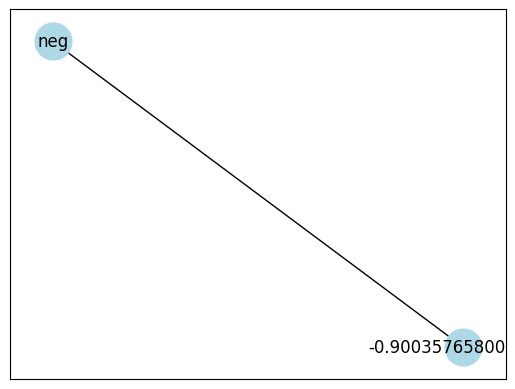

In [41]:
# Visualisasi pohon terbaik
plot_tree(best_individual)

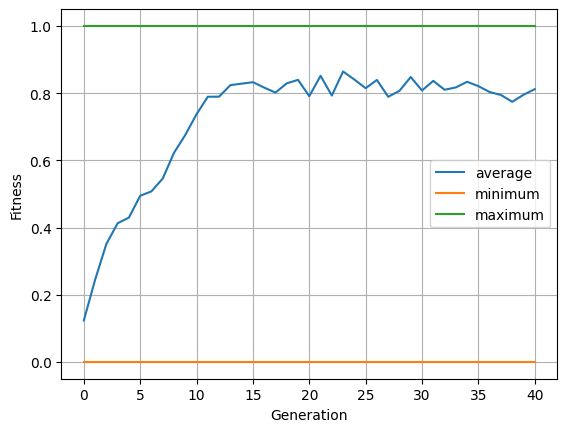

In [42]:
# Plotting fitness score over generations
gen = log.select("gen")
avg = log.select("avg")
min_ = log.select("min")
max_ = log.select("max")

plt.figure()
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Uji Coba Model atau Algoritma yang ditemukan oleh penerapan Algoritma Evolusi pada dataset

In [44]:
import random
from sklearn.metrics import accuracy_score, confusion_matrix # Import confusion_matrix

# Ambil secara acak 100 titik data dari dataset
random_indices = random.sample(range(len(X)), 100)
X_test_random = X[random_indices]
y_test_random = y[random_indices]

# Evaluasi model terbaik pada data acak
test_predictions_random = np.array([func(*x) for x in X_test_random])
test_predictions_random = np.round(test_predictions_random).astype(int)
test_accuracy_random = accuracy_score(y_test_random, test_predictions_random)

print("Accuracy on random 100 data points: ", test_accuracy_random)
print("Confusion Matrix on random 100 data points:")
print(confusion_matrix(y_test_random, test_predictions_random)) # Now confusion_matrix is defined

Accuracy on random 100 data points:  1.0
Confusion Matrix on random 100 data points:
[[100]]
